In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

from fastdtw import fastdtw

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import matplotlib.pyplot as plt

import rasterio
from osgeo import gdal, ogr, osr
from gdalconst import *
gdal.UseExceptions()

import datetime as dt


import stac

## Obter imagens da área de interesse via STAC (BrazilDataCube)

In [2]:
# Criar conexão com o servidor da STAC
bdc_stac_service = stac.STAC('http://brazildatacube.dpi.inpe.br/')

# Obter itens filtrados pelo objeto JSON (https://stacspec.org/STAC-api.html#operation/postSearchSTAC)
# Filtro: 200 primeiras imagens da coleção 'LC8SR-1' que intersectam o ponto -46.872, -17.150 ("centroide" de paracatu).
item = bdc_stac_service.search({'collections':['LC8SR-1'], 
                                "intersects": {"type": "Point",
                                               "coordinates": [-46.872, -17.150]},
                                'limit': 200})

# Mostrar quantas imagens foram recuperadas
len(item.features)

93

## Criar um dicionário com as datas e links das imagens

In [3]:
links = {}

# Percorrer todos o itens obtidos da STAC
for i in item.features:
    
    # Adquirir a data da imagem
    date = i['properties']['datetime'][0:10]
    
    # Inserir um item no dicionário 'links' com (chave = data da imagem) e (valor = URL da imagem).
    # IV selecionado: NDVI
    links[date] = {'ndvi':i['assets']['sr_ndvi']['href'], 'fmask':i['assets']['Fmask4']['href']}

## Abrir arquivo de pontos e extrair coordenadas

In [4]:
# Abrir arquivo de pontos
df = gpd.read_file('./DADOS/pt_inicial_10qtd.geojson')

# Gerar duas listas (lat e lon) com as coordenadas dos pontos
lat = []
lon = []
for i in df.geometry:
    lon.append(i.x)
    lat.append(i.y)

## Amostrar os valores das imagens para os pontos de referência

### NDVI

In [5]:
# Para evitar a execução total dessa célula, salvei o resultado dela (dicionário) em um arquivo. 
# Caso o arquivo seja encontrado, o processamento é evitado
try:
    out = np.load('./DADOS/out_seriess.npy', allow_pickle=True).item()
    print("Arquivo aberto com sucesso!")
except:
    print("Arquivo não encontrado, amostrando pontos pela série de imagens...")
    
    # Criar um dicionário de saída
    out = {}
    # Percorrer todas os pares data(k)/URL(v) da lista 'links'
    for k,v in links.items():
        # Abrir a imagem da URL
        with rasterio.open(v['ndvi']) as src:
            # Obter o valores dos pixel da imagem para as coordenadas dos pontos (amostrar valores)
            val = [x[0] for x in src.sample(zip(lon,lat))]

            # Inserir o item no dicionário 'out' com (chave = data da imagem) e (valor = lista de valores da imagem).
            out[k] = val
                    
    print("Amostragem finalizada!")
    
    try:
        np.save('./DADOS/out_seriess.npy', out)
        print('O resultado foi salvo')
    except:
        print('O resultado não foi salvo')

Arquivo não encontrado, amostrando pontos pela série de imagens...
Amostragem finalizada!
O resultado foi salvo


In [38]:
# Inserir os valores obtidos como colunas no dataframe dos pontos
for k,v in out.items():
    df.insert(loc=2,column=dt.datetime.strptime(k,'%Y-%m-%d'), value=v)
    
df.drop(['geometry', 'PIVOID'],1, inplace=True)
df.rename(columns={'id': 'date'}, inplace=True)
df = df.set_index('date').T/10000

### Cloud mask

In [11]:
try:
    mask = np.load('./DADOS/out_series_mask.npy', allow_pickle=True).item()
    print("Arquivo aberto com sucesso!")
except:
    print("Arquivo não encontrado, amostrando pontos pela série de imagens...")
    
    # Criar um dicionário de saída
    mask = {}
    # Percorrer todas os pares data(k)/URL(v) da lista 'links'
    for k,v in links.items():
        # Abrir a imagem da URL
        with rasterio.open(v['fmask']) as src:
            # Obter o valores dos pixel da imagem para as coordenadas dos pontos (amostrar valores)
            val = [x[0] for x in src.sample(zip(lon,lat))]

            # Inserir o item no dicionário 'out' com (chave = data da imagem) e (valor = lista de valores da imagem).
            mask[k] = val
                    
    print("Amostragem finalizada!")
    
    try:
        np.save('./DADOS/out_ref_series.npy', mask)
        print('O resultado foi salvo')
    except:
        print('O resultado não foi salvo')

Arquivo não encontrado, amostrando pontos pela série de imagens...
Amostragem finalizada!
O resultado foi salvo


In [39]:
df_mask = gpd.read_file('./DADOS/pt_inicial_10qtd.geojson')
# Inserir os valores obtidos como colunas no dataframe dos pontos
for k,v in mask.items():
    df_mask.insert(loc=2,column=dt.datetime.strptime(k,'%Y-%m-%d'), value=v)
    
df_mask.drop(['geometry','PIVOID'],1, inplace=True)
df_mask.rename(columns={'id': 'date'}, inplace=True)
df_mask = df_mask.set_index('date').T

df_filtrado = pd.DataFrame(((-df_mask.mask(df_mask != 0)+1)*df))
df_interpolado = df_filtrado.interpolate(method='linear', axis=0)

In [40]:
df_interpolado

date,0,1,2,3,4,5,6,7,8,9,...,10920,10921,10922,10923,10924,10925,10926,10927,10928,10929
2016-08-15,0.2077,0.2122,0.2079,0.2360,0.3402,0.2326,0.21630,0.2106,0.2217,0.2088,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-31,0.1907,0.1935,0.1902,0.2139,0.2953,0.1970,0.18150,0.1937,0.2072,0.2032,...,0.1566,0.1597,0.1504,0.15920,0.1520,0.19600,0.1812,0.15060,0.1579,0.1605
2016-09-16,0.2121,0.2112,0.2105,0.2336,0.2736,0.2291,0.20535,0.2050,0.2154,0.2090,...,0.1615,0.1657,0.1561,0.16615,0.1548,0.18395,0.1856,0.15615,0.1627,0.1662
2016-10-02,0.2122,0.2054,0.2215,0.2430,0.3049,0.2405,0.22920,0.2163,0.2412,0.2102,...,0.1664,0.1717,0.1618,0.17310,0.1576,0.17190,0.1900,0.16170,0.1675,0.1719
2016-10-18,0.2773,0.2769,0.2786,0.2852,0.3687,0.2718,0.29170,0.2763,0.2753,0.2763,...,0.1403,0.1563,0.1439,0.18270,0.1410,0.16910,0.2614,0.13380,0.1407,0.1560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-23,0.3623,0.3608,0.3415,0.3467,0.6210,0.4762,0.35010,0.3693,0.3427,0.3569,...,0.3209,0.2375,0.3096,0.23300,0.3556,0.51580,0.3697,0.28340,0.2949,0.2384
2020-07-09,0.3128,0.3422,0.3030,0.3138,0.6005,0.4175,0.32190,0.3359,0.3129,0.3155,...,0.2738,0.2106,0.4307,0.21970,0.4731,0.27080,0.2524,0.38000,0.3005,0.2270
2020-07-25,0.3018,0.3644,0.2868,0.3108,0.5416,0.3792,0.31260,0.3533,0.3019,0.3075,...,0.3058,0.2418,0.6985,0.24520,0.7154,0.23100,0.2103,0.64920,0.5136,0.2774
2020-08-10,0.2950,0.3861,0.2844,0.3198,0.5339,0.3662,0.31300,0.3709,0.2967,0.2989,...,0.3597,0.3883,0.6215,0.42470,0.7112,0.24245,0.2309,0.73120,0.5207,0.4962


In [41]:
valores = {'observações inválidas (n=93)':df_filtrado.isna().sum(), '%':[(x/93)*100 for x in df_filtrado.isna().sum()]}
valores_invalidos = pd.DataFrame(data=valores)
valores_invalidos.index.rename('ponto', inplace=True)
valores_invalidos

,observações inválidas (n=93),%
ponto,,
0,39,41.935484
1,39,41.935484
2,38,40.860215
3,40,43.010753
4,38,40.860215
...,...,...
10925,43,46.236559
10926,43,46.236559
10927,41,44.086022


## Definição dos anos agrícolas

In [42]:
anos_ag = {'2016':[dt.datetime(2016, 9, 1), dt.datetime(2017, 8, 31)],
           '2017':[dt.datetime(2017, 9, 1), dt.datetime(2018, 8, 31)],
           '2018':[dt.datetime(2018, 9, 1), dt.datetime(2019, 8, 31)],
           '2019':[dt.datetime(2019, 9, 1), dt.datetime(2020, 8, 31)]}

## Cortar séries pelos anos agricolas

In [49]:
df_interpolado_anos = {}

for ano in anos_ag.keys():
    df_interpolado_anos[ano] = df_interpolado.loc[anos_ag[ano][0]:anos_ag[ano][1]].reset_index(drop=True)
    
np.save('./DADOS/dict_test.npy', df_interpolado_anos)


## Plot

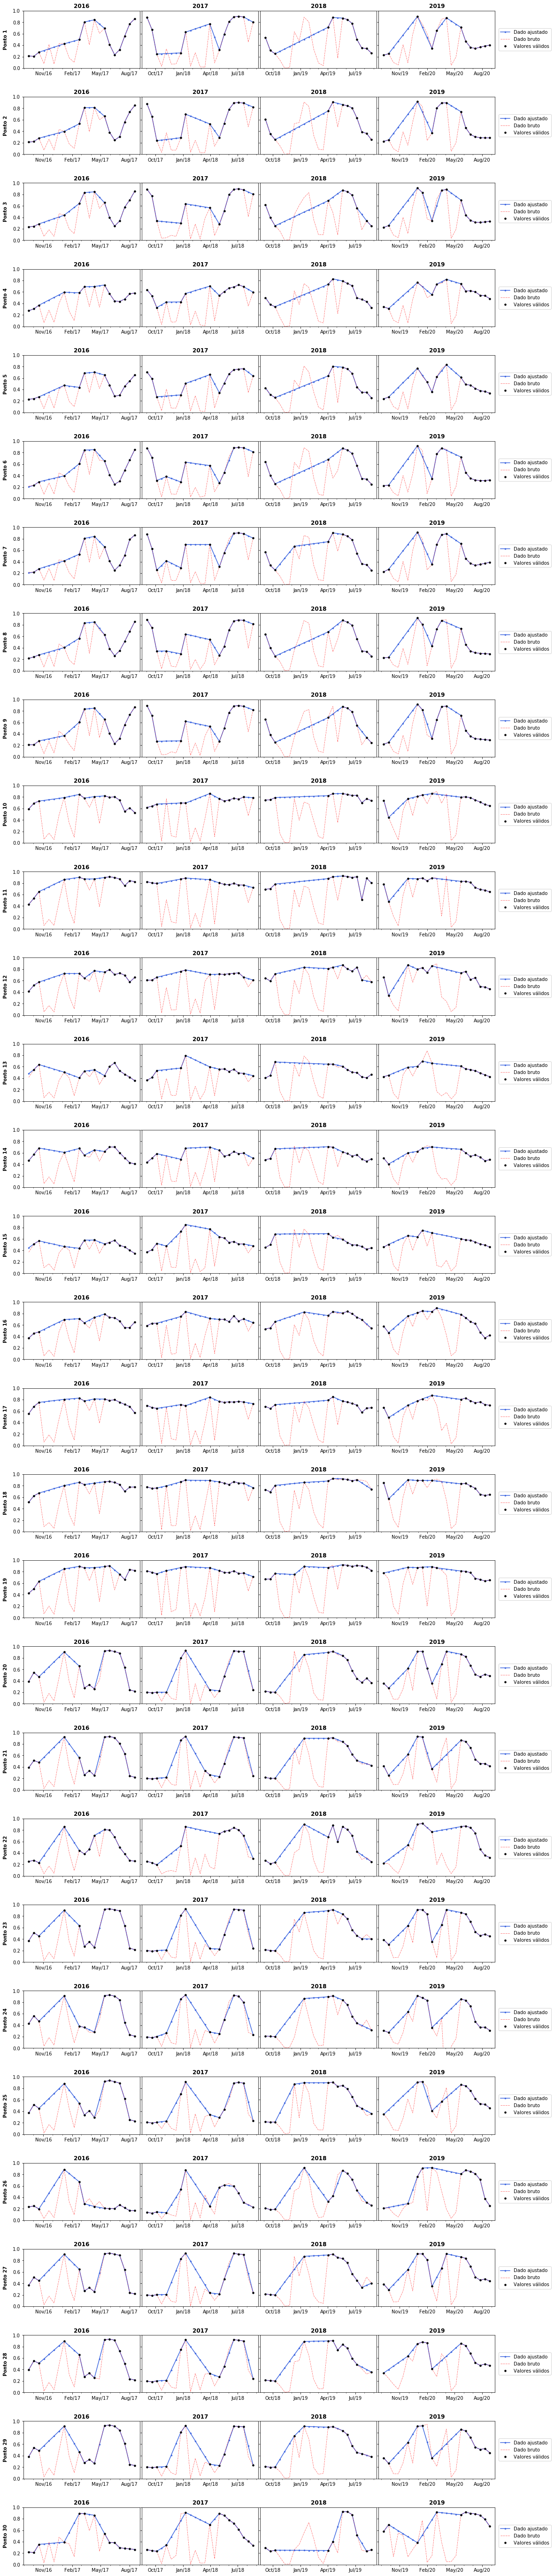

In [43]:
fig, ax = plt.subplots(df_interpolado.shape[1]-10900,len(anos_ag),figsize=(18,100),sharey=True)
fig.subplots_adjust(wspace = .015,hspace=.5)

for linha in range(df_interpolado.shape[1]-10900):
    ponto = linha + 1
    for (coluna,ano), intervalo in zip(enumerate(anos_ag),anos_ag.values()):
        
        ax[linha,coluna].set_ylim(0,1)

        months = mdates.MonthLocator(interval=3)
        month_fmt = mdates.DateFormatter('%b/%y')
        
        months_minor = mdates.MonthLocator()
        
        ax[linha,coluna].get_xaxis().set_minor_locator(months_minor)
        ax[linha,coluna].get_xaxis().set_major_locator(months)
        ax[linha,coluna].get_xaxis().set_major_formatter(month_fmt)

        ax[linha,coluna].set_title(ano,weight='bold')

        ax[linha,coluna].plot(df_interpolado.loc[intervalo[0]:intervalo[1],ponto],marker='.',ms=5, label='Dado ajustado', color='royalblue');
        ax[linha,coluna].plot(df.loc[intervalo[0]:intervalo[1],ponto],lw=.5, color='red', ls='-.', label='Dado bruto');
        ax[linha,coluna].plot(df_filtrado.loc[intervalo[0]:intervalo[1],ponto],marker='.',lw=0, mec='black', mfc='black', ms=7, label='Valores válidos');

    ax[linha,0].set_ylabel('Ponto {}'.format(ponto),labelpad=10,weight='bold')
    ax[linha,3].legend(bbox_to_anchor=(1.5, .5), loc='center right');

In [62]:
classif = pd.DataFrame(np.load('./DADOS/classif.npy', allow_pickle=True), columns=['2016', '2017', '2018', '2019'])
classif

,2016,2017,2018,2019
0,False,False,False,True
1,False,False,False,True
2,False,False,True,True
3,False,False,False,True
4,True,True,True,True
...,...,...,...,...
10925,False,False,False,False
10926,False,True,True,True
10927,True,True,True,False
10928,True,True,False,False


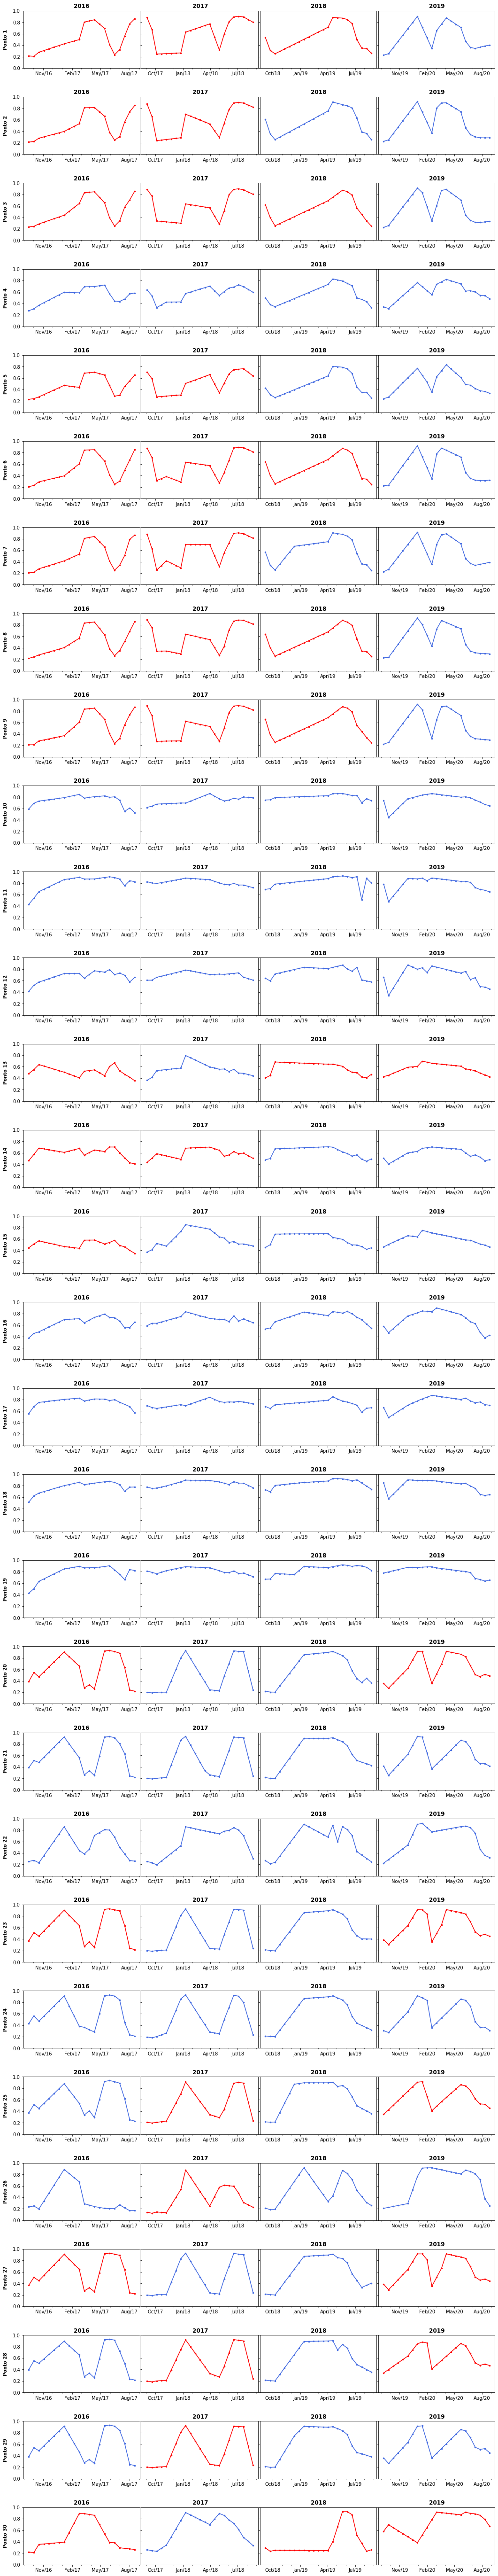

In [68]:
fig, ax = plt.subplots(df_interpolado.shape[1]-10900,len(anos_ag),figsize=(18,100),sharey=True)
fig.subplots_adjust(wspace = .015,hspace=.5)

for linha in range(df_interpolado.shape[1]-10900):
    ponto = linha + 1
    for (coluna,ano), intervalo in zip(enumerate(anos_ag),anos_ag.values()):
        
        if not classif.loc[ponto, ano]:
            cor = 'red'
        else:
            cor = 'royalblue'
        
        ax[linha,coluna].set_ylim(0,1)

        months = mdates.MonthLocator(interval=3)
        month_fmt = mdates.DateFormatter('%b/%y')
        
        months_minor = mdates.MonthLocator()
        
        ax[linha,coluna].get_xaxis().set_minor_locator(months_minor)
        ax[linha,coluna].get_xaxis().set_major_locator(months)
        ax[linha,coluna].get_xaxis().set_major_formatter(month_fmt)

        ax[linha,coluna].set_title(ano,weight='bold')

        ax[linha,coluna].plot(df_interpolado.loc[intervalo[0]:intervalo[1],ponto],marker='.',ms=5, label='Dado ajustado', color=cor);
#         ax[linha,coluna].plot(df.loc[intervalo[0]:intervalo[1],ponto],lw=.5, color='red', ls='-.', label='Dado bruto');
#         ax[linha,coluna].plot(df_filtrado.loc[intervalo[0]:intervalo[1],ponto],marker='.',lw=0, mec='black', mfc='black', ms=7, label='Valores válidos');

    ax[linha,0].set_ylabel('Ponto {}'.format(ponto),labelpad=10,weight='bold')
#     ax[linha,3].legend(bbox_to_anchor=(1.5, .5), loc='center right');